# Moving Circles Transformer

In [1]:
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
import gc
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

In [2]:
class Transformer(nn.Module):
    def __init__(self, n_input, n_output, seq_len, n_head, dim_ff, num_layers, position_encoding):
        super().__init__()

        self.n_input = n_input
        self.n_output = n_output
        self.n_head = n_head
        self.dim_ff = dim_ff
        self.num_layers = num_layers
        self.position_encoding = position_encoding
        self.seq_len = seq_len

        self.transformerlayer = nn.TransformerEncoderLayer(n_input, n_head, dim_feedforward=dim_ff, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.transformerlayer, num_layers)
        self.fc = nn.Linear(n_input, n_output)

    def position_encode(self):
        pe = torch.zeros(self.seq_len, self.n_input).to(device)
        pos = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.n_input, 2).float() * (-np.log(10000.0) / self.n_input))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        return pe
    
    def forward(self, X):
        x = X.to(device)
        if self.position_encoding:
            pe = self.position_encode()
            pe = pe.expand(X.size(0), -1, -1)
            x = X + pe
        y = self.transformer_encoder(x)
        y = self.fc(y)
        return y

In [3]:
class TransformerModel:
    def __init__(self, lstm, loss_fn, optimizer, seq_len, n_output, model_name="transformer"):
        self.model = lstm
        self.loss_fn = loss_fn
        self.optim = optimizer
        self.seq_len = seq_len
        self.n_output = n_output
        self.model_name = model_name

    def train(self, train_loader, n_epochs=10, learning=1e-2):
        train_loss = []
        best_loss = 1e10

        self.model.train()
        
        for i in range(n_epochs):
            start = time.time()
            avg_loss = 0.
            for X, y in train_loader:
                loss = 0.
                curr_batch_size = X.shape[0]

                X, y = X.to(device), y.to(device)
                self.optim.zero_grad()

                output = self.model(X)

                output = torch.transpose(output, 1, 2)
                y = torch.transpose(y, 1, 2)

                loss += self.loss_fn(output, y)
                
                loss.backward()
                self.optim.step()
                avg_loss += loss.item()

            end = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start, end)
            if best_loss > avg_loss:
                best_loss = avg_loss
                torch.save({self.model_name: self.model.state_dict(), self.model_name+"_optimizer": self.optim.state_dict()}, self.model_name+'-model.pt')

            train_loss.append(avg_loss)
            
            print("Epoch " + str(i + 1) + "/" + str(n_epochs))
            print("Time: " + str(epoch_mins) + " minutes " + str(epoch_secs) + " seconds")
            print("Training loss: " + str(avg_loss))
            print()

        return train_loss
    
    def epoch_time(self, start_time, end_time):
        elapsed = end_time - start_time
        elapsed_mins = int(elapsed / 60)
        elapsed_secs = int(elapsed - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def find_lens(self, X):
        X_lens = []
        for batch in X:
            count = 0
            for time in batch:
                if torch.count_nonzero(time) == 0:
                    break
                else:
                    count += 1
            X_lens.append(count)
        return X_lens

    def eval(self, test_loader):
        check = torch.load(self.model_name+"-model.pt")
        self.model.load_state_dict(check[self.model_name])

        confusion = np.zeros((self.n_output, self.n_output))

        gc.collect()
        torch.cuda.empty_cache()

        with torch.no_grad():
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            test_loss = 0.
            self.model.eval()

            for x, y in test_loader:
                curr_batch_size = x.shape[0]
                X, Y = x.to(device), y.to(device)

                output = self.model(X)

                X_lens = self.find_lens(X)

                top_value, top_index = output.topk(1)
                out = torch.zeros(curr_batch_size, self.seq_len, self.n_output).to(device)
                for clip in range(curr_batch_size):
                    for k in range(self.seq_len):
                        out[clip][k][top_index[clip][k].item()] = 1

                output = torch.transpose(output, 1, 2)
                y_hat = torch.transpose(y, 1, 2).to(device)
                test_loss += self.loss_fn(output, y_hat).item()
                correct, total = accuracy(y.cpu().numpy(), out.cpu().numpy(), correct, total)

                true, pred = devector(y.cpu().numpy(), out.cpu().numpy())

                confusion += confusion_matrix(true, pred)
        
        ff_accuracy = correct / total
        return ff_accuracy, confusion
    
    
    def random_samples(self, X, pad=0.):
        X_random = []
        X_lens = self.find_lens(X)
        for i in range(X.shape[0]):
            X_batch = np.random.normal(size=(X_lens[i], X.shape[-1]))
            if X_lens[i] < self.seq_len:
                X_pad = np.array([[pad]*X.shape[-1]]*(self.seq_len - X_lens[i]))
                X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
        X_random = np.array(X_random)
        return X_random
    
    def rand_test(self, test_loader, n_samples=20, percentile=90):
        rand_acc_array = []
        for sample in range(n_samples):
            correct = np.zeros(self.seq_len)
            total = np.zeros(self.seq_len)
            
            self.model.eval()

            with torch.no_grad():

                for x, y in test_loader:
                    loss = 0.
                    curr_batch_size = x.shape[0]
                    X_random = torch.from_numpy(self.random_samples(x)).float().to(device)
                    y = y.to(device)

                    X_lens = self.find_lens(x)
                    output = self.model(X_random)
                    top_value, top_index = output.topk(1)
                    out = torch.zeros(curr_batch_size, self.seq_len, self.n_output)
                    for clip in range(curr_batch_size):
                        for k in range(self.seq_len):
                            out[clip][k][top_index[clip][k].item()] = 1

                    output = torch.transpose(output, 1, 2)
                    y_hat = torch.transpose(y, 1, 2).to(device)
                    loss += self.loss_fn(output, y_hat).item()
                    
                    correct, total = accuracy(y.cpu().numpy(), out.cpu().numpy(), correct, total)

                    
            rand_acc = correct / total
            rand_acc_array.append(rand_acc)
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot

In [4]:
def findIndex(val, arr):
    index = -1
    for x in range(arr.size):
        if val == arr[x]:
            index = x
            break
    return index

def accuracy(target, prob, correct, tot):
    for i in range(prob.shape[1]):
        correctCount = correct[i]
        totalCount = tot[i]
        for j in range(prob.shape[0]):
            if np.count_nonzero(target[j][i]) != 0:
                if findIndex(1., target[j][i]) == findIndex(1., prob[j][i]):
                    correctCount += 1
                totalCount += 1
        correct[i] = correctCount
        tot[i] = totalCount
    return correct, tot

In [5]:
def vectorize(y, c=2):
    new_y = np.zeros((y.shape[0], y.shape[1], c))
    for batch in range(y.shape[0]):
        for time in range(y.shape[1]):
            cl = y[batch][time]
            if cl < c:
                new_y[batch][time][int(cl)] = 1.
    return new_y

In [6]:
def devector(true, pred):
    new_y_true = []
    new_y_pred = []
    for batch in range(true.shape[0]):
        for time in range(true.shape[1]):
            if np.count_nonzero(true[batch][time]) != 0:
                i = findIndex(1., true[batch][time])
                new_y_true.append(i)
                j = findIndex(1., pred[batch][time])
                new_y_pred.append(j)
    return np.array(new_y_true), np.array(new_y_pred)

In [7]:
with open(f"appr_retr_timesegments.pkl", 'rb') as f:
    X_train, y_train, len_train, X_test, y_test, len_test = pickle.load(f)

for batch, batch_len in enumerate(len_train):
    y_train[batch, batch_len:] = np.array([2]*(y_train.shape[-1] - batch_len))

for batch, batch_len in enumerate(len_test):
    y_test[batch, batch_len:] = np.array([2]*(y_test.shape[-1] - batch_len))

y_train = vectorize(y_train)
y_test = vectorize(y_test)

batch_size = 32

train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [8]:
n_input = 300
n_hidden = 32
seq_len = 129
learning_rate = 5e-4
EPOCHS = 100
num_head=4
num_layers=1
n_class = 2

transformer_multipos = Transformer(n_input, n_class, seq_len, num_head, n_hidden, num_layers, True).to(device)
loss_fn_multipos = nn.CrossEntropyLoss()
optimizer_multipos = optim.Adam(transformer_multipos.parameters(), lr=learning_rate)

model_multipos = TransformerModel(transformer_multipos, loss_fn_multipos, optimizer_multipos, seq_len, n_class, "transformer_multipos")


In [9]:
#train_loss_multipos = model_multipos.train(train_loader, n_epochs=EPOCHS, learning=learning_rate)

xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss_multipos)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(0, EPOCHS)
plt.xticks([j*20 for j in range(EPOCHS // 20 + 1)])
plt.title("Training Loss")
plt.show()

NameError: name 'train_loss_multipos' is not defined

In [9]:
transformer_multipos_accuracy, confusion = model_multipos.eval(test_loader)

In [10]:
%store transformer_multipos_accuracy

Stored 'transformer_multipos_accuracy' (ndarray)


In [11]:
print(confusion)

[[46592.  5862.]
 [ 6218. 47295.]]


In [14]:
transformer_multipos_rand_acc = model_multipos.rand_test(test_loader, n_samples=20)

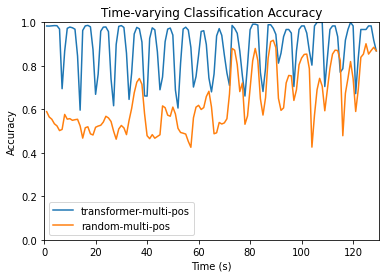

In [15]:
xAx = [i for i in range(1,130)]
plt.plot(xAx, transformer_multipos_accuracy, label="transformer-multi-pos")
plt.plot(xAx, transformer_multipos_rand_acc, label="random-multi-pos")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,130)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()